In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [2]:
with open(r"data/ATE_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/ATE_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/ATE_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
model = fasttext.load_model("cc.en.300.bin")

In [4]:
word_embedding = model.get_word_vector('hello')
print(word_embedding)

[ 1.57576188e-01  4.37820926e-02 -4.51271934e-03  6.65931404e-02
  7.70346820e-02  4.85855248e-03  8.19822028e-03  6.52402919e-03
  9.25899856e-03  3.53899002e-02 -2.31395271e-02 -4.91807126e-02
 -8.32642540e-02  1.56014524e-02  2.54856616e-01  3.45423706e-02
 -1.07451361e-02 -7.80188590e-02 -7.08099529e-02  7.62385577e-02
 -6.09613657e-02  4.48625796e-02 -7.29744136e-02  1.30583309e-02
  3.14881057e-02 -3.10055036e-02  1.66004002e-02  1.74405202e-02
 -7.35838860e-02  1.18252613e-01 -1.21330231e-01 -4.09253240e-02
  2.93969568e-02  4.84445989e-02 -1.33816330e-02 -1.74765270e-02
  7.51308873e-02  9.97046307e-02 -4.00476977e-02  4.05735290e-03
 -7.21896589e-02 -4.43356819e-02 -1.22628408e-03  7.56693557e-02
  3.98401320e-02  3.22643593e-02  1.95914153e-02  4.68016043e-02
 -1.46228177e-02  1.12967767e-01  3.15065160e-02 -1.02312110e-01
  1.58124104e-01 -2.76147053e-02 -3.39851156e-02 -1.77006852e-02
 -5.73529862e-04  1.10789239e-01 -1.64533369e-02 -3.14955460e-03
 -4.22914140e-02  1.11429

In [5]:
def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
                embedding.append(model.get_word_vector(word))
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 83 # maximum length of word in 1 text 
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(model.get_word_vector("Hello"))] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [6]:

x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_33147/1681424001.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings)


In [7]:
x_train.size()

torch.Size([906, 83, 300])

In [8]:
def convert_labels_to_fixed_length(labels, max_length):
    new_list=[]
    label_to_index = {'B': 0, 'I': 1, 'O': 2,'<pad>':3}
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 3
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 83
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [9]:
y_train.size()

torch.Size([906, 83])

In [10]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [11]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class GRUTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUTagger, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 4
learning_rate = 0.001
num_epochs = 150
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = GRUTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_33147/3447244848.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_33147/3447244848.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_33147/3447244848.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_33147/3447244848.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/150, Train Loss: 1.1910307854413986, Val Loss: 0.8914263248443604, Val F1: 0.31506097818289236, Train F1: 0.22996408156232073


  1%|█▉                                                                                                                                                | 2/150 [00:02<02:37,  1.06s/it]

Epoch 2/150, Train Loss: 0.6795654967427254, Val Loss: 0.47701796889305115, Val F1: 0.3153062084070424, Train F1: 0.30348815184449934


  2%|██▉                                                                                                                                               | 3/150 [00:03<02:36,  1.06s/it]

Epoch 3/150, Train Loss: 0.5120422914624214, Val Loss: 0.4381353259086609, Val F1: 0.3153153153153153, Train F1: 0.30463622429404197


  3%|███▉                                                                                                                                              | 4/150 [00:04<02:36,  1.07s/it]

Epoch 4/150, Train Loss: 0.43945520371198654, Val Loss: 0.4003778398036957, Val F1: 0.31535968346171656, Train F1: 0.3039827625944591


  3%|████▊                                                                                                                                             | 5/150 [00:05<02:34,  1.07s/it]

Epoch 5/150, Train Loss: 0.415424145758152, Val Loss: 0.3682020604610443, Val F1: 0.3154040404040404, Train F1: 0.30385228443365586


  4%|█████▊                                                                                                                                            | 6/150 [00:06<02:34,  1.08s/it]

Epoch 6/150, Train Loss: 0.36996936798095703, Val Loss: 0.3446826636791229, Val F1: 0.3154040404040404, Train F1: 0.30497306135668445


  5%|██████▊                                                                                                                                           | 7/150 [00:07<02:34,  1.08s/it]

Epoch 7/150, Train Loss: 0.37200741469860077, Val Loss: 0.3258865773677826, Val F1: 0.31776822581420283, Train F1: 0.30428839125604734


  5%|███████▊                                                                                                                                          | 8/150 [00:08<02:30,  1.06s/it]

Epoch 8/150, Train Loss: 0.33642688393592834, Val Loss: 0.3105350434780121, Val F1: 0.3268076231164585, Train F1: 0.31160242971033086


  6%|████████▊                                                                                                                                         | 9/150 [00:09<02:28,  1.05s/it]

Epoch 9/150, Train Loss: 0.31094345077872276, Val Loss: 0.2932182252407074, Val F1: 0.3333424787413625, Train F1: 0.3144638835950113


  7%|█████████▋                                                                                                                                       | 10/150 [00:10<02:27,  1.05s/it]

Epoch 10/150, Train Loss: 0.30573156476020813, Val Loss: 0.2793136239051819, Val F1: 0.34535490077991104, Train F1: 0.3251951056823317


  7%|██████████▋                                                                                                                                      | 11/150 [00:11<02:26,  1.05s/it]

Epoch 11/150, Train Loss: 0.3027740716934204, Val Loss: 0.26483166217803955, Val F1: 0.36232249795112953, Train F1: 0.3496482752376447


  8%|███████████▌                                                                                                                                     | 12/150 [00:12<02:25,  1.05s/it]

Epoch 12/150, Train Loss: 0.27377460338175297, Val Loss: 0.2512509524822235, Val F1: 0.42698677375547506, Train F1: 0.3910155386178981


  9%|████████████▌                                                                                                                                    | 13/150 [00:13<02:24,  1.05s/it]

Epoch 13/150, Train Loss: 0.26036370545625687, Val Loss: 0.23774273693561554, Val F1: 0.4485983427338045, Train F1: 0.4272986477166975


  9%|█████████████▌                                                                                                                                   | 14/150 [00:14<02:22,  1.05s/it]

Epoch 14/150, Train Loss: 0.2511163465678692, Val Loss: 0.2263343185186386, Val F1: 0.5168941360296492, Train F1: 0.46471877414557566


 10%|██████████████▌                                                                                                                                  | 15/150 [00:15<02:22,  1.05s/it]

Epoch 15/150, Train Loss: 0.23873072862625122, Val Loss: 0.21559906005859375, Val F1: 0.5700244505522258, Train F1: 0.5223040222581112


 11%|███████████████▍                                                                                                                                 | 16/150 [00:16<02:21,  1.06s/it]

Epoch 16/150, Train Loss: 0.22195905819535255, Val Loss: 0.20693576335906982, Val F1: 0.5922404958122861, Train F1: 0.5890058093258563


 11%|████████████████▍                                                                                                                                | 17/150 [00:18<02:20,  1.05s/it]

Epoch 17/150, Train Loss: 0.22665815986692905, Val Loss: 0.20165015757083893, Val F1: 0.6781427359595251, Train F1: 0.606633618054419


 12%|█████████████████▍                                                                                                                               | 18/150 [00:19<02:19,  1.06s/it]

Epoch 18/150, Train Loss: 0.20903659984469414, Val Loss: 0.19336852431297302, Val F1: 0.6619560194861207, Train F1: 0.6478093402267335


 13%|██████████████████▎                                                                                                                              | 19/150 [00:20<02:19,  1.07s/it]

Epoch 19/150, Train Loss: 0.21008818969130516, Val Loss: 0.1874796599149704, Val F1: 0.6800181619845281, Train F1: 0.6788720214053419


 13%|███████████████████▎                                                                                                                             | 20/150 [00:21<02:18,  1.07s/it]

Epoch 20/150, Train Loss: 0.20018570870161057, Val Loss: 0.1826220154762268, Val F1: 0.7035678510334548, Train F1: 0.688485870710221


 14%|████████████████████▎                                                                                                                            | 21/150 [00:22<02:16,  1.06s/it]

Epoch 21/150, Train Loss: 0.19208494201302528, Val Loss: 0.17810216546058655, Val F1: 0.7178006479824237, Train F1: 0.6980277211241451


 15%|█████████████████████▎                                                                                                                           | 22/150 [00:23<02:15,  1.06s/it]

Epoch 22/150, Train Loss: 0.19001289457082748, Val Loss: 0.17472994327545166, Val F1: 0.7352879338970676, Train F1: 0.7128182077818506


 15%|██████████████████████▏                                                                                                                          | 23/150 [00:24<02:15,  1.06s/it]

Epoch 23/150, Train Loss: 0.17600882425904274, Val Loss: 0.1700577288866043, Val F1: 0.7307134937774187, Train F1: 0.7432907337170671


 16%|███████████████████████▏                                                                                                                         | 24/150 [00:25<02:13,  1.06s/it]

Epoch 24/150, Train Loss: 0.18032076954841614, Val Loss: 0.16646572947502136, Val F1: 0.7448121139929186, Train F1: 0.7295814982958955


 17%|████████████████████████▏                                                                                                                        | 25/150 [00:26<02:12,  1.06s/it]

Epoch 25/150, Train Loss: 0.17677653208374977, Val Loss: 0.16573569178581238, Val F1: 0.7683204231016157, Train F1: 0.7498955507260461


 17%|█████████████████████████▏                                                                                                                       | 26/150 [00:27<02:10,  1.05s/it]

Epoch 26/150, Train Loss: 0.17694443836808205, Val Loss: 0.16311542689800262, Val F1: 0.7749094214945641, Train F1: 0.7580826057764956


 18%|██████████████████████████                                                                                                                       | 27/150 [00:28<02:09,  1.05s/it]

Epoch 27/150, Train Loss: 0.1655330155044794, Val Loss: 0.15978777408599854, Val F1: 0.735067324246336, Train F1: 0.775896188688201


 19%|███████████████████████████                                                                                                                      | 28/150 [00:29<02:08,  1.05s/it]

Epoch 28/150, Train Loss: 0.16162794083356857, Val Loss: 0.15736116468906403, Val F1: 0.7606294307728789, Train F1: 0.7859499583259033


 19%|████████████████████████████                                                                                                                     | 29/150 [00:30<02:07,  1.05s/it]

Epoch 29/150, Train Loss: 0.17013187520205975, Val Loss: 0.15920376777648926, Val F1: 0.7790598799313013, Train F1: 0.7667591921234325


 20%|█████████████████████████████                                                                                                                    | 30/150 [00:31<02:06,  1.05s/it]

Epoch 30/150, Train Loss: 0.16043659672141075, Val Loss: 0.15368743240833282, Val F1: 0.7780840743645284, Train F1: 0.7689961931633841


 21%|█████████████████████████████▉                                                                                                                   | 31/150 [00:32<02:05,  1.06s/it]

Epoch 31/150, Train Loss: 0.1548174424096942, Val Loss: 0.15212231874465942, Val F1: 0.7693866492476014, Train F1: 0.7815782362643622


 21%|██████████████████████████████▉                                                                                                                  | 32/150 [00:33<01:58,  1.00s/it]

Epoch 32/150, Train Loss: 0.15529120154678822, Val Loss: 0.1544889360666275, Val F1: 0.7321676384153436, Train F1: 0.8056993245962646


 22%|███████████████████████████████▉                                                                                                                 | 33/150 [00:34<01:59,  1.02s/it]

Epoch 33/150, Train Loss: 0.1525896368548274, Val Loss: 0.15001650154590607, Val F1: 0.7534807239322537, Train F1: 0.793643339565592


 23%|████████████████████████████████▊                                                                                                                | 34/150 [00:35<01:59,  1.03s/it]

Epoch 34/150, Train Loss: 0.15149507392197847, Val Loss: 0.15008388459682465, Val F1: 0.7825493640909462, Train F1: 0.7925448706219139


 23%|█████████████████████████████████▊                                                                                                               | 35/150 [00:37<02:12,  1.16s/it]

Epoch 35/150, Train Loss: 0.1564479097723961, Val Loss: 0.1531188040971756, Val F1: 0.7987111465431246, Train F1: 0.7965368849933309


 24%|██████████████████████████████████▊                                                                                                              | 36/150 [00:40<03:11,  1.68s/it]

Epoch 36/150, Train Loss: 0.14672802295535803, Val Loss: 0.14915041625499725, Val F1: 0.757667824364018, Train F1: 0.7915313905626382


 25%|███████████████████████████████████▊                                                                                                             | 37/150 [00:42<03:26,  1.83s/it]

Epoch 37/150, Train Loss: 0.14008847158402205, Val Loss: 0.147670179605484, Val F1: 0.7727268860223955, Train F1: 0.8135197803012211


 25%|████████████████████████████████████▋                                                                                                            | 38/150 [00:45<03:57,  2.12s/it]

Epoch 38/150, Train Loss: 0.1471408000215888, Val Loss: 0.14646345376968384, Val F1: 0.7773459383753502, Train F1: 0.8091479133042089


 26%|█████████████████████████████████████▋                                                                                                           | 39/150 [00:47<04:02,  2.18s/it]

Epoch 39/150, Train Loss: 0.1437498638406396, Val Loss: 0.1504955291748047, Val F1: 0.7910318895138874, Train F1: 0.7928595958382776


 27%|██████████████████████████████████████▋                                                                                                          | 40/150 [00:51<04:59,  2.73s/it]

Epoch 40/150, Train Loss: 0.14691253751516342, Val Loss: 0.1439891904592514, Val F1: 0.799802114244793, Train F1: 0.7906005946608996


 27%|███████████████████████████████████████▋                                                                                                         | 41/150 [00:54<05:08,  2.83s/it]

Epoch 41/150, Train Loss: 0.13692518044263124, Val Loss: 0.142095148563385, Val F1: 0.7840970797770792, Train F1: 0.8235825192993915


 28%|████████████████████████████████████████▌                                                                                                        | 42/150 [00:56<04:40,  2.60s/it]

Epoch 42/150, Train Loss: 0.13399126660078764, Val Loss: 0.1422768235206604, Val F1: 0.7981992985395108, Train F1: 0.8297041323670697


 29%|█████████████████████████████████████████▌                                                                                                       | 43/150 [01:00<05:19,  2.98s/it]

Epoch 43/150, Train Loss: 0.13418834935873747, Val Loss: 0.14235727488994598, Val F1: 0.7743733256203645, Train F1: 0.8181884435208386


 29%|██████████████████████████████████████████▌                                                                                                      | 44/150 [01:02<04:40,  2.65s/it]

Epoch 44/150, Train Loss: 0.13540922105312347, Val Loss: 0.14525923132896423, Val F1: 0.7616768474521023, Train F1: 0.8202255854022612


 30%|███████████████████████████████████████████▌                                                                                                     | 45/150 [01:07<06:06,  3.49s/it]

Epoch 45/150, Train Loss: 0.12786884140223265, Val Loss: 0.14213156700134277, Val F1: 0.7771048495147846, Train F1: 0.8326671194902454


 31%|████████████████████████████████████████████▍                                                                                                    | 46/150 [01:44<23:22, 13.49s/it]

Epoch 46/150, Train Loss: 0.1321013830602169, Val Loss: 0.14300687611103058, Val F1: 0.7981391674483889, Train F1: 0.8262181136912086


 31%|█████████████████████████████████████████████▍                                                                                                   | 47/150 [01:47<17:31, 10.21s/it]

Epoch 47/150, Train Loss: 0.12582225538790226, Val Loss: 0.14354208111763, Val F1: 0.7663747544363005, Train F1: 0.8400161478226174


 32%|██████████████████████████████████████████████▍                                                                                                  | 48/150 [01:48<12:58,  7.64s/it]

Epoch 48/150, Train Loss: 0.1290244348347187, Val Loss: 0.14552351832389832, Val F1: 0.7631475915453464, Train F1: 0.8333387463269581


 33%|███████████████████████████████████████████████▎                                                                                                 | 49/150 [01:49<09:31,  5.66s/it]

Epoch 49/150, Train Loss: 0.1271375473588705, Val Loss: 0.14088724553585052, Val F1: 0.7872931120249467, Train F1: 0.8312105070800805


 33%|████████████████████████████████████████████████▎                                                                                                | 50/150 [01:50<07:01,  4.21s/it]

Epoch 50/150, Train Loss: 0.1261478029191494, Val Loss: 0.1397636979818344, Val F1: 0.807532476690828, Train F1: 0.8379244407480686


 34%|█████████████████████████████████████████████████▎                                                                                               | 51/150 [01:51<05:16,  3.20s/it]

Epoch 51/150, Train Loss: 0.12169596925377846, Val Loss: 0.14134255051612854, Val F1: 0.8122057601487743, Train F1: 0.8467313279180266


 35%|██████████████████████████████████████████████████▎                                                                                              | 52/150 [01:52<04:05,  2.50s/it]

Epoch 52/150, Train Loss: 0.1190615613013506, Val Loss: 0.14097432792186737, Val F1: 0.780894583936491, Train F1: 0.8538380865512237


 35%|███████████████████████████████████████████████████▏                                                                                             | 53/150 [01:53<03:13,  2.00s/it]

Epoch 53/150, Train Loss: 0.12013667449355125, Val Loss: 0.14015008509159088, Val F1: 0.7920654143465651, Train F1: 0.839999410853151


 36%|████████████████████████████████████████████████████▏                                                                                            | 54/150 [01:54<02:38,  1.65s/it]

Epoch 54/150, Train Loss: 0.1209437120705843, Val Loss: 0.14194811880588531, Val F1: 0.805396724286981, Train F1: 0.8446761457499181


 37%|█████████████████████████████████████████████████████▏                                                                                           | 55/150 [01:54<02:11,  1.39s/it]

Epoch 55/150, Train Loss: 0.11153319384902716, Val Loss: 0.1423981487751007, Val F1: 0.7774414083052519, Train F1: 0.8527029170475566


 37%|██████████████████████████████████████████████████████▏                                                                                          | 56/150 [01:55<01:53,  1.21s/it]

Epoch 56/150, Train Loss: 0.1160410176962614, Val Loss: 0.13978010416030884, Val F1: 0.8010051228506768, Train F1: 0.8543395594387703


 38%|███████████████████████████████████████████████████████                                                                                          | 57/150 [01:56<01:40,  1.08s/it]

Epoch 57/150, Train Loss: 0.11054574698209763, Val Loss: 0.1450999230146408, Val F1: 0.7697496107779424, Train F1: 0.8511615072473846


 39%|████████████████████████████████████████████████████████                                                                                         | 58/150 [01:57<01:31,  1.01it/s]

Epoch 58/150, Train Loss: 0.11144478060305119, Val Loss: 0.16265210509300232, Val F1: 0.7374648927521165, Train F1: 0.8497372945442733


 39%|█████████████████████████████████████████████████████████                                                                                        | 59/150 [01:57<01:24,  1.08it/s]

Epoch 59/150, Train Loss: 0.1099200532771647, Val Loss: 0.15893085300922394, Val F1: 0.7312983459417025, Train F1: 0.8498705496566227


 40%|██████████████████████████████████████████████████████████                                                                                       | 60/150 [01:58<01:19,  1.13it/s]

Epoch 60/150, Train Loss: 0.11245062574744225, Val Loss: 0.1400243192911148, Val F1: 0.794367152305345, Train F1: 0.8510647170370921


 41%|██████████████████████████████████████████████████████████▉                                                                                      | 61/150 [01:59<01:16,  1.17it/s]

Epoch 61/150, Train Loss: 0.1087677339091897, Val Loss: 0.14413122832775116, Val F1: 0.8019750615128997, Train F1: 0.8535094922068782


 41%|███████████████████████████████████████████████████████████▉                                                                                     | 62/150 [02:00<01:13,  1.20it/s]

Epoch 62/150, Train Loss: 0.10303268115967512, Val Loss: 0.1422693282365799, Val F1: 0.7861221778447162, Train F1: 0.8712037451846488


 42%|████████████████████████████████████████████████████████████▉                                                                                    | 63/150 [02:01<01:11,  1.22it/s]

Epoch 63/150, Train Loss: 0.09899483993649483, Val Loss: 0.14194652438163757, Val F1: 0.7831303229552483, Train F1: 0.8844886015608672


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 64/150 [02:01<01:09,  1.24it/s]

Epoch 64/150, Train Loss: 0.10212483629584312, Val Loss: 0.14429843425750732, Val F1: 0.7886366574238276, Train F1: 0.8745996114561411


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 65/150 [02:02<01:07,  1.26it/s]

Epoch 65/150, Train Loss: 0.09724701195955276, Val Loss: 0.14838899672031403, Val F1: 0.7797854422893066, Train F1: 0.8834507913903176


 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 66/150 [02:03<01:06,  1.27it/s]

Epoch 66/150, Train Loss: 0.10285005532205105, Val Loss: 0.14468689262866974, Val F1: 0.787034711225368, Train F1: 0.8544972791236952


 45%|████████████████████████████████████████████████████████████████▊                                                                                | 67/150 [02:04<01:04,  1.28it/s]

Epoch 67/150, Train Loss: 0.09967038128525019, Val Loss: 0.1465563327074051, Val F1: 0.7847622398168198, Train F1: 0.8745143265616016


 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 68/150 [02:04<01:03,  1.29it/s]

Epoch 68/150, Train Loss: 0.1043664775788784, Val Loss: 0.15122859179973602, Val F1: 0.7846813503900391, Train F1: 0.8683067614021529


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 69/150 [02:05<01:03,  1.28it/s]

Epoch 69/150, Train Loss: 0.09406429342925549, Val Loss: 0.14939811825752258, Val F1: 0.7818895067580698, Train F1: 0.890615030175602


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 70/150 [02:06<01:02,  1.27it/s]

Epoch 70/150, Train Loss: 0.08831786690279841, Val Loss: 0.15024890005588531, Val F1: 0.7848742434619501, Train F1: 0.8991715889285887


 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 71/150 [02:07<01:03,  1.25it/s]

Epoch 71/150, Train Loss: 0.08938046731054783, Val Loss: 0.15907607972621918, Val F1: 0.7718765290090709, Train F1: 0.8960309756659208


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 72/150 [02:08<01:03,  1.22it/s]

Epoch 72/150, Train Loss: 0.09375890158116817, Val Loss: 0.15353116393089294, Val F1: 0.783659488843457, Train F1: 0.8747972596869121


 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 73/150 [02:09<01:03,  1.22it/s]

Epoch 73/150, Train Loss: 0.09862196631729603, Val Loss: 0.15416434407234192, Val F1: 0.7807968327501035, Train F1: 0.8930863739943841


 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 74/150 [02:09<01:02,  1.21it/s]

Epoch 74/150, Train Loss: 0.08517631096765399, Val Loss: 0.157014861702919, Val F1: 0.7883828406791196, Train F1: 0.9003844129446069


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 75/150 [02:10<01:00,  1.24it/s]

Epoch 75/150, Train Loss: 0.09596571419388056, Val Loss: 0.14900565147399902, Val F1: 0.7988691911148244, Train F1: 0.886704647991817


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 76/150 [02:11<00:59,  1.24it/s]

Epoch 76/150, Train Loss: 0.08373753819614649, Val Loss: 0.15300501883029938, Val F1: 0.7886188671679116, Train F1: 0.8950651618451905


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 77/150 [02:12<01:00,  1.21it/s]

Epoch 77/150, Train Loss: 0.08561169449239969, Val Loss: 0.15678326785564423, Val F1: 0.7745445119951632, Train F1: 0.9092751522629495


 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 78/150 [02:13<00:58,  1.23it/s]

Epoch 78/150, Train Loss: 0.08079509995877743, Val Loss: 0.16112567484378815, Val F1: 0.7725266324292798, Train F1: 0.9117687177813916


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 79/150 [02:13<00:56,  1.25it/s]

Epoch 79/150, Train Loss: 0.07833297364413738, Val Loss: 0.16681316494941711, Val F1: 0.7721733355173472, Train F1: 0.9118474595808956


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 80/150 [02:14<00:55,  1.26it/s]

Epoch 80/150, Train Loss: 0.07572029484435916, Val Loss: 0.1628439873456955, Val F1: 0.7679851329541859, Train F1: 0.9130626166426462


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 81/150 [02:15<00:54,  1.27it/s]

Epoch 81/150, Train Loss: 0.07836251426488161, Val Loss: 0.15714307129383087, Val F1: 0.7890511690927685, Train F1: 0.9107887539006349


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 82/150 [02:16<00:53,  1.28it/s]

Epoch 82/150, Train Loss: 0.07817739900201559, Val Loss: 0.16279231011867523, Val F1: 0.7742376220906104, Train F1: 0.9205963474770471


 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 83/150 [02:17<00:52,  1.28it/s]

Epoch 83/150, Train Loss: 0.0777570279315114, Val Loss: 0.1611080765724182, Val F1: 0.7914928338042335, Train F1: 0.9076112498649775


 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 84/150 [02:17<00:51,  1.28it/s]

Epoch 84/150, Train Loss: 0.0820914264768362, Val Loss: 0.16379554569721222, Val F1: 0.7962263718429541, Train F1: 0.9012708238248921


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 85/150 [02:18<00:50,  1.28it/s]

Epoch 85/150, Train Loss: 0.07603878807276487, Val Loss: 0.16230544447898865, Val F1: 0.7935081764697988, Train F1: 0.91282828706088


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 86/150 [02:19<00:50,  1.28it/s]

Epoch 86/150, Train Loss: 0.07198004936799407, Val Loss: 0.15920090675354004, Val F1: 0.7922871684690486, Train F1: 0.9193952984437768


 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 87/150 [02:20<00:49,  1.28it/s]

Epoch 87/150, Train Loss: 0.06585980905219913, Val Loss: 0.16257812082767487, Val F1: 0.7806228421287867, Train F1: 0.9362759973246055


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 88/150 [02:20<00:49,  1.26it/s]

Epoch 88/150, Train Loss: 0.07036521099507809, Val Loss: 0.1673157513141632, Val F1: 0.7820416947520071, Train F1: 0.9301043757424963


 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 89/150 [02:21<00:48,  1.26it/s]

Epoch 89/150, Train Loss: 0.06173615111038089, Val Loss: 0.16940002143383026, Val F1: 0.7729415505393172, Train F1: 0.9362267548895781


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 90/150 [02:22<00:47,  1.28it/s]

Epoch 90/150, Train Loss: 0.0614803247153759, Val Loss: 0.16773231327533722, Val F1: 0.7851388722732219, Train F1: 0.9398494423984902


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 91/150 [02:23<00:45,  1.28it/s]

Epoch 91/150, Train Loss: 0.06391004985198379, Val Loss: 0.16621120274066925, Val F1: 0.78604669281768, Train F1: 0.9225488850683423


 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 92/150 [02:24<00:44,  1.29it/s]

Epoch 92/150, Train Loss: 0.061683809850364923, Val Loss: 0.17097897827625275, Val F1: 0.7782174630061623, Train F1: 0.9397235868572482


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 93/150 [02:24<00:43,  1.30it/s]

Epoch 93/150, Train Loss: 0.06092833308503032, Val Loss: 0.1735364943742752, Val F1: 0.7715850773350347, Train F1: 0.9422620385062215


 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 94/150 [02:25<00:43,  1.30it/s]

Epoch 94/150, Train Loss: 0.06060826685279608, Val Loss: 0.17821529507637024, Val F1: 0.7735385593856066, Train F1: 0.933371738365408


 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 95/150 [02:26<00:42,  1.30it/s]

Epoch 95/150, Train Loss: 0.05620435765013099, Val Loss: 0.17720024287700653, Val F1: 0.7734822007744162, Train F1: 0.9484349759978304


 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 96/150 [02:27<00:41,  1.30it/s]

Epoch 96/150, Train Loss: 0.05752535630017519, Val Loss: 0.18796207010746002, Val F1: 0.7616393394179419, Train F1: 0.936005541262736


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 97/150 [02:27<00:40,  1.30it/s]

Epoch 97/150, Train Loss: 0.05680883629247546, Val Loss: 0.18517982959747314, Val F1: 0.7675090504037874, Train F1: 0.9478918524566962


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 98/150 [02:28<00:40,  1.30it/s]

Epoch 98/150, Train Loss: 0.053466242738068104, Val Loss: 0.19221924245357513, Val F1: 0.7681015408513002, Train F1: 0.9473771242820855


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 99/150 [02:29<00:39,  1.30it/s]

Epoch 99/150, Train Loss: 0.056011960841715336, Val Loss: 0.1843746155500412, Val F1: 0.7696552524153759, Train F1: 0.940000652346872


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 100/150 [02:30<00:39,  1.26it/s]

Epoch 100/150, Train Loss: 0.06004578107967973, Val Loss: 0.18294058740139008, Val F1: 0.7827590874715641, Train F1: 0.9422379271142463


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 101/150 [02:31<00:38,  1.27it/s]

Epoch 101/150, Train Loss: 0.05642759008333087, Val Loss: 0.18016692996025085, Val F1: 0.7802908180648901, Train F1: 0.9498970764812644


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 102/150 [02:31<00:37,  1.27it/s]

Epoch 102/150, Train Loss: 0.04872847627848387, Val Loss: 0.18035916984081268, Val F1: 0.7829522464526634, Train F1: 0.9608074036321121


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 103/150 [02:32<00:36,  1.28it/s]

Epoch 103/150, Train Loss: 0.04779093526303768, Val Loss: 0.18734249472618103, Val F1: 0.7739584824428132, Train F1: 0.9583796640746898


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 104/150 [02:33<00:35,  1.29it/s]

Epoch 104/150, Train Loss: 0.04818370100110769, Val Loss: 0.185163214802742, Val F1: 0.7847965992229495, Train F1: 0.9587449144310879


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 105/150 [02:34<00:34,  1.29it/s]

Epoch 105/150, Train Loss: 0.053854003082960844, Val Loss: 0.18745490908622742, Val F1: 0.7777820016919706, Train F1: 0.9563720702775755


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 106/150 [02:34<00:33,  1.29it/s]

Epoch 106/150, Train Loss: 0.045146184507757425, Val Loss: 0.18966354429721832, Val F1: 0.7610759218112021, Train F1: 0.9627644397807869


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 107/150 [02:35<00:33,  1.30it/s]

Epoch 107/150, Train Loss: 0.045587151078507304, Val Loss: 0.19320039451122284, Val F1: 0.776624321317338, Train F1: 0.9620907047807853


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 108/150 [02:36<00:32,  1.29it/s]

Epoch 108/150, Train Loss: 0.046074071899056435, Val Loss: 0.2048778533935547, Val F1: 0.7583458366294379, Train F1: 0.9596321064837022


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 109/150 [02:37<00:31,  1.29it/s]

Epoch 109/150, Train Loss: 0.04518386395648122, Val Loss: 0.21094290912151337, Val F1: 0.7544568451766033, Train F1: 0.9475592927424028


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 110/150 [02:37<00:30,  1.30it/s]

Epoch 110/150, Train Loss: 0.040857631247490644, Val Loss: 0.19960413873195648, Val F1: 0.7709169246375783, Train F1: 0.9665543220621179


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 111/150 [02:38<00:30,  1.29it/s]

Epoch 111/150, Train Loss: 0.03967013908550143, Val Loss: 0.1989278644323349, Val F1: 0.7711802543056937, Train F1: 0.9713734678086148


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 112/150 [02:39<00:29,  1.29it/s]

Epoch 112/150, Train Loss: 0.03786295326426625, Val Loss: 0.20168812572956085, Val F1: 0.7741137128173166, Train F1: 0.9729492086404762


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 113/150 [02:40<00:28,  1.29it/s]

Epoch 113/150, Train Loss: 0.04151173238642514, Val Loss: 0.20356060564517975, Val F1: 0.774401126518201, Train F1: 0.9643365712804651


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 114/150 [02:41<00:28,  1.27it/s]

Epoch 114/150, Train Loss: 0.04565628618001938, Val Loss: 0.1997014433145523, Val F1: 0.7750982114070822, Train F1: 0.9602121487340548


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 115/150 [02:41<00:27,  1.28it/s]

Epoch 115/150, Train Loss: 0.037351446226239204, Val Loss: 0.20439709722995758, Val F1: 0.7781894253646313, Train F1: 0.9704190210971014


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 116/150 [02:42<00:26,  1.28it/s]

Epoch 116/150, Train Loss: 0.03821141505613923, Val Loss: 0.20853817462921143, Val F1: 0.7700681431269026, Train F1: 0.9694959182961438


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 117/150 [02:43<00:22,  1.50it/s]

Epoch 117/150, Train Loss: 0.035203557228669524, Val Loss: 0.2054731845855713, Val F1: 0.7734947983217734, Train F1: 0.9764765682200263


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 118/150 [02:43<00:18,  1.70it/s]

Epoch 118/150, Train Loss: 0.03365601948462427, Val Loss: 0.2167939692735672, Val F1: 0.764804299269069, Train F1: 0.9746948933760324


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 119/150 [02:43<00:16,  1.88it/s]

Epoch 119/150, Train Loss: 0.03784277569502592, Val Loss: 0.2244051992893219, Val F1: 0.7574798125587625, Train F1: 0.972340831828462


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 120/150 [02:44<00:14,  2.02it/s]

Epoch 120/150, Train Loss: 0.03923330013640225, Val Loss: 0.24498577415943146, Val F1: 0.739085679214171, Train F1: 0.9673494184161997


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 121/150 [02:44<00:13,  2.13it/s]

Epoch 121/150, Train Loss: 0.04076529806479812, Val Loss: 0.23757843673229218, Val F1: 0.7440441106978174, Train F1: 0.9626064541039728


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 122/150 [02:45<00:12,  2.22it/s]

Epoch 122/150, Train Loss: 0.03849714994430542, Val Loss: 0.22440630197525024, Val F1: 0.7516488621617516, Train F1: 0.9640016219853023


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 123/150 [02:45<00:11,  2.30it/s]

Epoch 123/150, Train Loss: 0.03660469874739647, Val Loss: 0.2175797075033188, Val F1: 0.7701253878612455, Train F1: 0.9610941554752754


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 124/150 [02:45<00:11,  2.33it/s]

Epoch 124/150, Train Loss: 0.03664397355169058, Val Loss: 0.22121523320674896, Val F1: 0.7612309226083904, Train F1: 0.9703556271647307


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 125/150 [02:46<00:10,  2.33it/s]

Epoch 125/150, Train Loss: 0.03217040840536356, Val Loss: 0.23227041959762573, Val F1: 0.7593912673097994, Train F1: 0.9750653537649473


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/150 [02:46<00:10,  2.31it/s]

Epoch 126/150, Train Loss: 0.03539459966123104, Val Loss: 0.22175218164920807, Val F1: 0.7675754159708742, Train F1: 0.9709909495478485


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 127/150 [02:47<00:09,  2.35it/s]

Epoch 127/150, Train Loss: 0.029230694053694606, Val Loss: 0.23303374648094177, Val F1: 0.7513402865014539, Train F1: 0.9825804975841372


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 128/150 [02:47<00:09,  2.35it/s]

Epoch 128/150, Train Loss: 0.029756049625575542, Val Loss: 0.2293512374162674, Val F1: 0.7599787046803627, Train F1: 0.9798897493423216


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 129/150 [02:48<00:09,  2.33it/s]

Epoch 129/150, Train Loss: 0.02790874056518078, Val Loss: 0.23179075121879578, Val F1: 0.7618747698888296, Train F1: 0.9843205148262939


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 130/150 [02:48<00:08,  2.36it/s]

Epoch 130/150, Train Loss: 0.0258264378644526, Val Loss: 0.23681104183197021, Val F1: 0.7645787767790192, Train F1: 0.9823078948075548


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 131/150 [02:48<00:08,  2.35it/s]

Epoch 131/150, Train Loss: 0.02601998602040112, Val Loss: 0.23912450671195984, Val F1: 0.7497810350145883, Train F1: 0.983398818439898


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 132/150 [02:49<00:07,  2.40it/s]

Epoch 132/150, Train Loss: 0.025495804147794843, Val Loss: 0.240567147731781, Val F1: 0.753091037631369, Train F1: 0.9834460369090202


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 133/150 [02:49<00:06,  2.43it/s]

Epoch 133/150, Train Loss: 0.026332576759159565, Val Loss: 0.23965448141098022, Val F1: 0.7505865169403014, Train F1: 0.9831146949938258


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 134/150 [02:50<00:06,  2.46it/s]

Epoch 134/150, Train Loss: 0.025476248003542423, Val Loss: 0.24796319007873535, Val F1: 0.7537458856529957, Train F1: 0.9822750653055765


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 135/150 [02:50<00:06,  2.48it/s]

Epoch 135/150, Train Loss: 0.023652571253478527, Val Loss: 0.24864895641803741, Val F1: 0.7434037239222615, Train F1: 0.9861190566228863


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 136/150 [02:50<00:05,  2.50it/s]

Epoch 136/150, Train Loss: 0.023992197355255485, Val Loss: 0.2499464899301529, Val F1: 0.747828955912805, Train F1: 0.9852346037946141


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 137/150 [02:51<00:05,  2.50it/s]

Epoch 137/150, Train Loss: 0.022945631062611938, Val Loss: 0.2534771263599396, Val F1: 0.7471253480055711, Train F1: 0.9847230828453963


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/150 [02:51<00:04,  2.49it/s]

Epoch 138/150, Train Loss: 0.021903424756601453, Val Loss: 0.24892698228359222, Val F1: 0.7538088314920149, Train F1: 0.986723821369925


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 139/150 [02:52<00:04,  2.49it/s]

Epoch 139/150, Train Loss: 0.020913208136335015, Val Loss: 0.24894896149635315, Val F1: 0.7602439971776384, Train F1: 0.9878924050583361


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 140/150 [02:52<00:04,  2.50it/s]

Epoch 140/150, Train Loss: 0.022920504678040743, Val Loss: 0.2563129961490631, Val F1: 0.7549006946118381, Train F1: 0.984277207554675


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 141/150 [02:52<00:03,  2.51it/s]

Epoch 141/150, Train Loss: 0.022953978972509503, Val Loss: 0.2563585042953491, Val F1: 0.747789357451916, Train F1: 0.9851119303896395


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 142/150 [02:53<00:03,  2.46it/s]

Epoch 142/150, Train Loss: 0.023002151399850845, Val Loss: 0.25863271951675415, Val F1: 0.7632251129151199, Train F1: 0.9856180202354567


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [02:53<00:02,  2.42it/s]

Epoch 143/150, Train Loss: 0.021241094218567014, Val Loss: 0.2490190863609314, Val F1: 0.7730500007832882, Train F1: 0.9830555151170699


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 144/150 [02:54<00:02,  2.39it/s]

Epoch 144/150, Train Loss: 0.021120490157045424, Val Loss: 0.251237690448761, Val F1: 0.7678604295089259, Train F1: 0.9859946937039871


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 145/150 [02:54<00:02,  2.39it/s]

Epoch 145/150, Train Loss: 0.01954996259883046, Val Loss: 0.2612361013889313, Val F1: 0.7569993903290761, Train F1: 0.9869996546764986


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [02:54<00:01,  2.41it/s]

Epoch 146/150, Train Loss: 0.01841306360438466, Val Loss: 0.26479512453079224, Val F1: 0.7595084978711615, Train F1: 0.9885044349076707


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 147/150 [02:55<00:01,  2.43it/s]

Epoch 147/150, Train Loss: 0.016943900263868272, Val Loss: 0.27027565240859985, Val F1: 0.7512357577588568, Train F1: 0.9906943179277496


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [02:55<00:00,  2.44it/s]

Epoch 148/150, Train Loss: 0.017826566472649574, Val Loss: 0.27032384276390076, Val F1: 0.7543396150088028, Train F1: 0.9911257817778052


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [02:56<00:00,  2.47it/s]

Epoch 149/150, Train Loss: 0.03639275173190981, Val Loss: 0.27069756388664246, Val F1: 0.7635081726301336, Train F1: 0.9875787067006839


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:56<00:00,  1.18s/it]

Epoch 150/150, Train Loss: 0.01694306021090597, Val Loss: 0.2770020365715027, Val F1: 0.7527799342213868, Train F1: 0.9907897527859102


In [12]:
# Save the model
torch.save(model.state_dict(), 't2_model3_fasttext.pth')

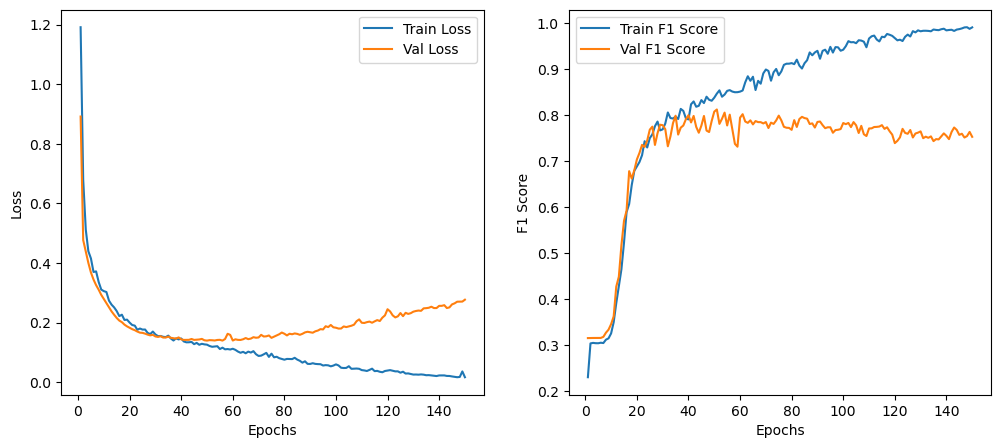

In [13]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()